In [2]:
!pip install dgl
#!DGLBACKEND=pytorch
#!export $DGLBACKEND
#import os
#os.environ["DGLBACKEND"] = "pytorch"
#print(os.environ["DGLBACKEND"])
import dgl
import numpy as np
#import tensorflow as tf
import torch as th

!pip install forgi
import forgi
import forgi.graph.bulge_graph as fgb
import forgi.threedee as ft
import forgi.threedee.model.coarse_grain as ftmc


import matplotlib.pyplot as plt
import networkx as nx
import os


In [6]:
print(th.__version__)
print(th.cuda.is_available())
!xz -d -v data.tar.xz
!tar -xf data.tar

1.10.0+cu111
True
data.tar.xz (1/1)
xz: data.tar.xz: No such file or directory



Ideas: 
*   use dgl.save_graph() to store a graph, so the structure can be used for several steps?
*   use forgi.threedee.model.coarse_grain.CoarseGrainRNA.rotate() to rotate cg RNAs and see if the classification changes

TODO:
*  future --> find where ernwin writes/stores output of structure for each n steps
*  finetune the model
*  make larger batch of training data for testing
*  include logger (maybe wandb?)



In [7]:
#Graph Building

#load coarse grain file
def load_cg_file(file): 
    cg = ftmc.CoarseGrainRNA.from_bg_file(file) 
    c_dict = dict(cg.coords)
    t_dict = dict(cg.twists)
    coord_dict = {}
    twist_dict = {}
    for e in c_dict:
        a = th.from_numpy(c_dict[e][0])
        b = th.from_numpy(c_dict[e][1])
        coord_dict[e] = a, b
        if e in t_dict:
            c = th.from_numpy(t_dict[e][0])
            d = th.from_numpy(t_dict[e][1])
            twist_dict[e] = c, d
        
    # Get elements and neighbours:
    connections = {}
    for elem in cg.sorted_element_iterator():
        neighbours = cg.connections(elem)
        if elem not in connections:
            connections[elem] = cg.connections(elem)
    return coord_dict, twist_dict, connections

def build_dgl_graph(coord_dict, twist_dict, connections):
    #dictionary to convert type
    type_transl = {
        "h": [1, 0, 0, 0, 0, 0],
        "i": [0, 1, 0, 0, 0, 0],
        "m": [0, 0, 1, 0, 0, 0],
        "s": [0, 0, 0, 1, 0, 0],
        "f": [0, 0, 0, 0, 1, 0],
        "t": [0, 0, 0, 0, 0, 1]
    } 

    #encode nodes numerically for dgl graph
    num_graph = {}
    elem_count = {}
    for num, n in enumerate(sorted(connections)):
        num_graph[n] = num
        if n[0] not in elem_count:
            elem_count[n[0]] = 1
        else:
            elem_count[n[0]] += 1

    #build graph and edges
    u = []
    v = []
    for node in connections:
        for c in connections[node]:
            u.append(num_graph[node])
            v.append(num_graph[c])

    graph = dgl.graph((th.tensor(u), th.tensor(v)))

    #initialise node attributes
    graph.ndata["type"] = th.zeros(graph.num_nodes(), 6, dtype=th.float32)
    graph.ndata["coord"] = th.zeros(graph.num_nodes(), 6, dtype=th.float32) #seperate coords into 2 sets of 3, so that the information of start and end is added?
    graph.ndata["twist"] = th.zeros(graph.num_nodes(), 6, dtype=th.float32)

    for elem in connections:
        graph.ndata["type"][num_graph[elem]] = th.tensor(type_transl[elem[0]], dtype=th.float32) 
        graph.ndata["coord"][num_graph[elem]] = th.tensor(np.concatenate(coord_dict[elem]), dtype=th.float32)
        if elem in twist_dict:
            graph.ndata["twist"][num_graph[elem]] = th.tensor(np.concatenate(twist_dict[elem]), dtype=th.float32)
  
    return graph


In [8]:
#create a dict with name and rmsd as labels
def get_rmsd_dict(rmsd_list):
    #rmsd_list = "./play_set/RMSD_list.txt"
    rmsd_dict = {}
    with open(rmsd_list, "r") as fh:
        for line in fh.readlines():
            name, rmsd = (line.rstrip()).split("\t")
            rmsd_dict[name] = float(rmsd)
    return rmsd_dict


In [19]:
#Graph Dataset Class
#TODO: adapt, so it can stand alone

from dgl.data import DGLDataset
class CGDataset(DGLDataset):
    def __init__(self, directory, rmsd_list):
        self.file_path = directory
        self.rmsd_list = rmsd_list
        super(CGDataset, self).__init__(name="cgRNA")
        
        
    def process(self):
        self.graphs = []
        rmsd_dict = get_rmsd_dict(self.rmsd_list)
        self.labels = []
        
        files = []
        filenames = next(os.walk(self.file_path), (None, None, []))[2]

        for file in filenames:
            if file.endswith(".cg"):
                files.append(file)
                self.labels.append(rmsd_dict[file])

        for struc in files:
            coord_dict, twist_dict, connections = load_cg_file(os.path.join(self.file_path, struc))
            graph = build_dgl_graph(coord_dict, twist_dict, connections)
            self.graphs.append(build_dgl_graph(coord_dict, twist_dict, connections))

        self.labels = th.tensor(self.labels)
  
    def __getitem__(self, i):
        return self.graphs[i], self.labels[i]

    def __len__(self):
        return len(self.graphs)
    
    #def save(self):
     #   dgl.save_graphs("./play_set/training_cg_graphs.dgl", self.graphs, labels=self.labels)


In [55]:
#Dataloading
import dgl.dataloading as dtl

b_size = 50

#load from cg files directly

training_dir = "./training_set"
rmsd_list = "train_rmsd_list.txt"

training_dataset = CGDataset(training_dir, rmsd_list)

#add randomisation as in Defining Data Loader from https://docs.dgl.ai/tutorials/blitz/5_graph_classification.html
train_dataloader = dtl.pytorch.GraphDataLoader(training_dataset, batch_size=b_size, shuffle=True) 


In [22]:
#Validation set
val_dir = "./val_set"
val_rmsd = "val_rmsd_list.txt"

val_dataset = CGDataset(val_dir, val_rmsd)

val_dataloader = dtl.pytorch.GraphDataLoader(val_dataset)

In [120]:
#Model
import dgl.nn as dglnn
from dgl.nn import GraphConv
import torch.nn.functional as F

# feed the 3 different node attributes one after the other though the first layer? like in https://discuss.dgl.ai/t/getting-started-with-multiple-node-features-in-homogenous-graph/919/2
# condense the 3 node attributes down to 1? see point above


#Coarse Grain RNA Classifier Model
class CG_Classifier(th.nn.Module):
    def __init__(self, num_features):
        super(CG_Classifier, self).__init__()
        
        '''
        self.conv1 = GraphConv(6, 48, activation=F.relu)
        self.conv2 = GraphConv(48, 24, activation=F.relu)
        self.conv3 = GraphConv(24, 12, activation=F.relu)
        '''
        self.conv1 = dglnn.TAGConv(6, 64, k=2, activation=F.relu)
        self.conv2 = dglnn.TAGConv(64, 32, k=2, activation=F.relu)
        self.conv3 = dglnn.TAGConv(32, 24, k=1, activation=F.relu)
        
        self.max_pool = dgl.nn.MaxPooling()
        
        self.sage_conv1 = dglnn.SAGEConv(24*num_features, 20, 'pool') 
        self.sage_conv2 = dglnn.SAGEConv(20, 16, 'pool')

        self.dense1 = th.nn.Linear(16, 512)
        self.dense2 = th.nn.Linear(512, 512)
        self.dense3 = th.nn.Linear(512, 512)
        self.classify = th.nn.Linear(512, 1)

    def forward(self, g):
        nt = g.ndata["type"]
        nc = g.ndata["coord"]
        nw = g.ndata["twist"]
        
        nt = self.conv1(g, nt)
        #nt = self.max_pool(g, nt)
        nt = self.conv2(g, nt)
        #nt = self.max_pool(g, nt)
        nt = self.conv3(g, nt)
        #nt = self.max_pool(g, nt)

        nc = self.conv1(g, nc)
        #nc = self.max_pool(g, nc)
        nc = self.conv2(g, nc)
        #nc = self.max_pool(g, nc)
        nc = self.conv3(g, nc)
        #nc = self.max_pool(g, nc)
        
        nw = self.conv1(g, nw)
        #nw = self.max_pool(g, nw)
        nw = self.conv2(g, nw)
        #nw = self.max_pool(g, nw)
        nw = self.conv3(g, nw)
        #nw = self.max_pool(g, nw)

        #TODO: Modify the readout function (maybe with the local scope below)
        
        #use pooling to have still a graph representation, after 2 layers of seperate conv
        #--> let conv run over the pooled graph
        #with g.local_scope():
        #    print(th.cat((nt, nc, nw), 0))
        #    g.ndata["combi"] = th.cat((nt, nc, nw), 0)
        #    tcw = g.ndata["combi"]
        #    tcw = self.conv3(g, tcw)
        #    tcw = self.max_pool(g, tcw)
            #tcw = th.cat((nt, nc, nw), 1) #use this for graph gen and again graph con


        #TODO: add readout function
        tcw = th.cat((nt, nc, nw), 1)
        g.ndata["combi"] = tcw
        combi = g.ndata["combi"]
        combi = self.sage_conv1(g, combi)
        combi = self.sage_conv2(g, combi)
        combi = self.max_pool(g, combi)

        tcw_mean = combi #dgl.mean_nodes(g, combi)
        #is the mean the right approach?
        #tcw_mean = tcw.mean(dim=0)
        tcw_mean = self.dense1(tcw_mean)
        tcw_mean = self.dense2(tcw_mean)
        tcw_mean = self.dense3(tcw_mean)
        
        return self.classify(tcw_mean)
    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: Using a target size (torch.Size([50])) that is different to the input size (torch.Size([50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Epoch 0: Training loss 74.3910, Validation loss 8.0770
Epoch 5: Training loss 7.9814, Validation loss 7.6443
Epoch 10: Training loss 7.1838, Validation loss 6.6686
Epoch 15: Training loss 7.0975, Validation loss 6.7172


<function matplotlib.pyplot.draw>

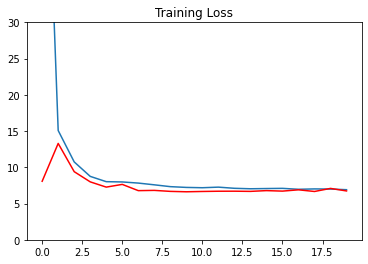

In [122]:
#Training
#TODO:  build a deeper neural network and refine pooling
#       tinker with hyperparameters

model = CG_Classifier(
    num_features=3 #len(graph.ndata)
)

opt = th.optim.Adam(model.parameters(), lr=0.001)
model.train()

epochs = 20

#val setup
val_losses = []

#training setup
epoch_losses = []
for epoch in range(epochs):
    epoch_loss = 0
    
    for iter, (batched_graph, batch_labels) in enumerate(train_dataloader):
        l = []
        for graph in dgl.unbatch(batched_graph): #ist there a way to use directly the batched_graph object?
            pred = model(graph)
            l.append(pred)
        
        logits = th.cat(l)
        loss = F.smooth_l1_loss(logits, batch_labels, reduction='mean')

        opt.zero_grad()
        loss.backward()
        opt.step()
        epoch_loss += loss.detach().item()
    
    epoch_loss /= (iter + 1)
    epoch_losses.append(epoch_loss)

    #val setup
    val_loss = 0
    for i, (v_graph, v_label) in enumerate(val_dataloader):
      val_pred = model(v_graph)
      v_loss = F.smooth_l1_loss(val_pred, v_label, reduction='mean')
      val_loss += v_loss.detach().item()

    val_loss /= (i + 1)
    
    val_losses.append(val_loss)

    if epoch % 5 == 0:
        print("Epoch {}: Training loss {:.4f}, Validation loss {:.4f}".format(epoch, epoch_loss, val_loss))

#plot the training run
plt.plot(epoch_losses)
plt.plot(val_losses, 'r')
plt.title("Training Loss")
plt.ylim(ymax=30, ymin=0)
plt.draw

In [123]:
#Test

model.eval()
test_dir = "./test_set"
test_rmsd = "test_rmsd_list.txt"

test_dataset = CGDataset(test_dir, test_rmsd)

test_dataloader = dtl.pytorch.GraphDataLoader(val_dataset)

test_losses = []
for test_graph, test_label in test_dataloader:
  test_pred = model(test_graph)
  test_loss = F.smooth_l1_loss(val_pred, val_label).item()
  test_losses.append(test_loss)
  #print("Test Prediction: {:.4f}; true RMSD: {:.4f}; loss: {:.4f}".format(test_pred.item(), test_label.item(), test_loss))

print(test_losses)
test_mean = np.mean(test_losses)
test_std = np.std(test_losses)
print(test_mean)
print(test_std)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  


[13.219627380371094, 13.219627380371094, 13.219627380371094, 13.219627380371094, 13.219627380371094, 13.219627380371094, 13.219627380371094, 13.219627380371094, 13.219627380371094, 13.219627380371094, 13.219627380371094, 13.219627380371094, 13.219627380371094, 13.219627380371094, 13.219627380371094, 13.219627380371094, 13.219627380371094, 13.219627380371094, 13.219627380371094, 13.219627380371094, 13.219627380371094, 13.219627380371094, 13.219627380371094, 13.219627380371094, 13.219627380371094, 13.219627380371094, 13.219627380371094, 13.219627380371094, 13.219627380371094, 13.219627380371094, 13.219627380371094, 13.219627380371094, 13.219627380371094, 13.219627380371094, 13.219627380371094, 13.219627380371094, 13.219627380371094, 13.219627380371094, 13.219627380371094, 13.219627380371094, 13.219627380371094, 13.219627380371094, 13.219627380371094, 13.219627380371094, 13.219627380371094, 13.219627380371094, 13.219627380371094, 13.219627380371094, 13.219627380371094, 13.219627380371094,